In [1]:
from platform import python_version

print(python_version())

3.6.12


In [2]:
# Based on https://github.com/alan-turing-institute/sktime/blob/master/examples/01_forecasting.ipynb (does not work)
# Use this instead: https://github.com/alan-turing-institute/sktime/blob/v0.4.3/examples/01_forecasting.ipynb

In [3]:
# Installing
# pip install sktime[all_extras]  # Installs soft dependencies as well

In [4]:
# %load_ext autoreload
# %autoreload 2

In [5]:
# Pre Release
import sys

sys.path.append(os.environ['DEV_SKTIME'])
print(os.environ['DEV_SKTIME'])

C:\Users\Nikhil\OneDrive - Southern Methodist University\my_libraries\my_python_libraries\sktime_forked


In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
from sktime.forecasting.all import *

%matplotlib inline

In [8]:
from sklearn.base import clone
from sklearn.model_selection import ParameterGrid
from sklearn.neighbors import KNeighborsRegressor

(<Figure size 1152x288 with 1 Axes>,
 <AxesSubplot:ylabel='Number of airline passengers'>)

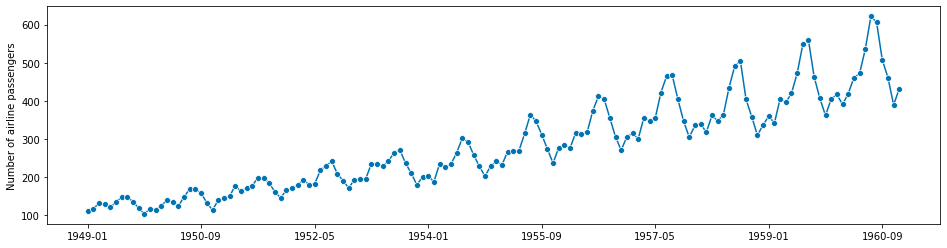

In [9]:
y = load_airline()
plot_series(y)

# These seems to be a bug in the X-axis. The end point should be in 1960

In [10]:
y.index

PeriodIndex(['1949-01', '1949-02', '1949-03', '1949-04', '1949-05', '1949-06',
             '1949-07', '1949-08', '1949-09', '1949-10',
             ...
             '1960-03', '1960-04', '1960-05', '1960-06', '1960-07', '1960-08',
             '1960-09', '1960-10', '1960-11', '1960-12'],
            dtype='period[M]', name='Period', length=144, freq='M')

108 36


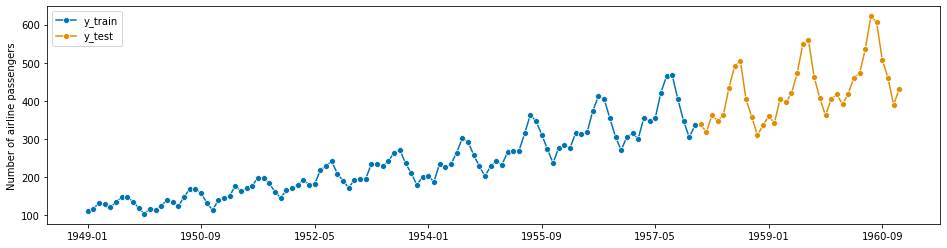

In [11]:
y_train, y_test = temporal_train_test_split(y, test_size=36)
plot_series(y_train, y_test, labels=["y_train", "y_test"]);
print(y_train.shape[0], y_test.shape[0])

In [12]:
fh = np.arange(len(y_test)) + 1
fh

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36])

In [13]:
fh = ForecastingHorizon(np.arange(len(y_test)) + 1, is_relative=True)
fh

ForecastingHorizon([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
            35, 36],
           dtype='int64', is_relative=True)

In [14]:
# fh = ForecastingHorizon(y_test.index, is_relative=False)
# fh

## Naive Forecast

In [15]:
help(NaiveForecaster)

Help on class NaiveForecaster in module sktime.forecasting.naive:

class NaiveForecaster(sktime.forecasting.base._sktime._OptionalForecastingHorizonMixin, sktime.forecasting.base._sktime._BaseWindowForecaster)
 |  NaiveForecaster is a forecaster that makes forecasts using simple
 |  strategies.
 |  
 |  Parameters
 |  ----------
 |  strategy : str{"last", "mean", "drift"}, optional (default="last")
 |      Strategy used to make forecasts:
 |  
 |      * "last" : forecast the last value in the
 |                  training series when sp is 1.
 |                  When sp is not 1,
 |                  last value of each season
 |                  in the last window will be
 |                  forecasted for each season.
 |      * "mean" : forecast the mean of last window
 |                   of training series when sp is 1.
 |                   When sp is not 1, mean of all values
 |                   in a season from last window will be
 |                   forecasted for each season.
 |

0.23195770387951434

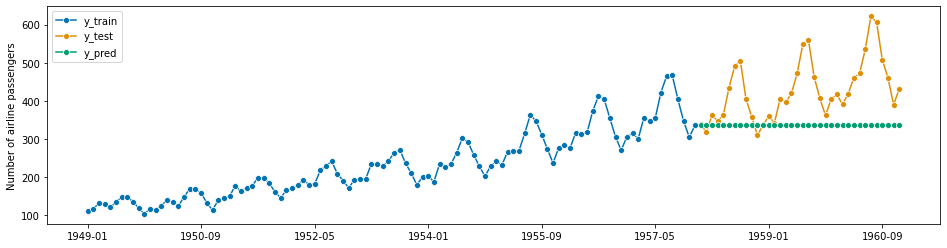

In [16]:
# using sktime
forecaster = NaiveForecaster(strategy="last")
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
smape_loss(y_pred, y_test)

0.145427686270316

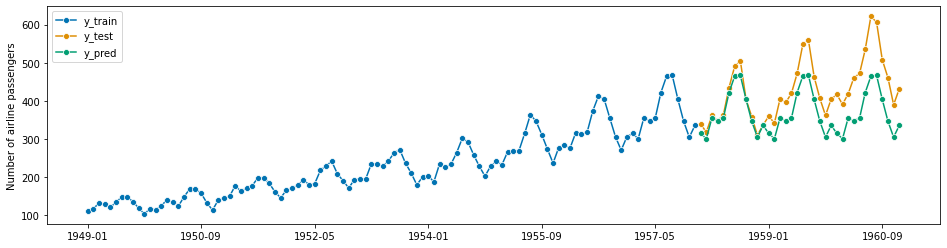

In [17]:
forecaster = NaiveForecaster(strategy="last", sp=12)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
smape_loss(y_pred, y_test)

In [18]:
# help(ReducedRegressionForecaster)

In [19]:
# help(forecaster.predict)

0.14008272913734346

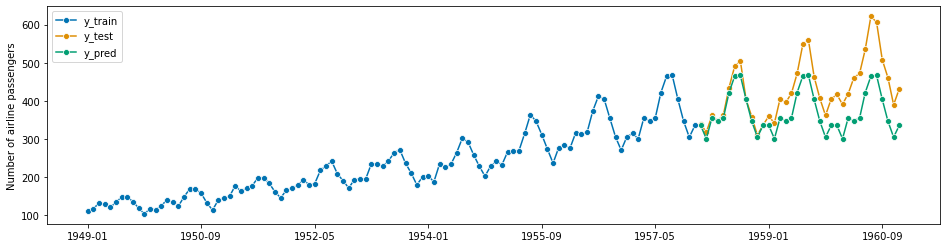

In [20]:
from sklearn.neighbors import KNeighborsRegressor

regressor = KNeighborsRegressor(n_neighbors=1)
forecaster = ReducedRegressionForecaster(regressor=regressor, window_length=12, strategy="recursive")
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)  # Looks to be recursive predictions (Double Check) 
# (i.e. forecasts from previous time are used as inputs to make predictions for the next time point)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
smape_loss(y_test, y_pred)

0.05108225285898997

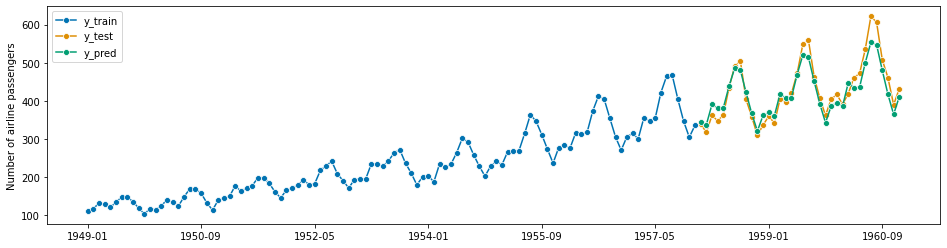

In [21]:
forecaster = ExponentialSmoothing(trend="add", seasonal="multiplicative", sp=12)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
smape_loss(y_test, y_pred)

0.06317641245925658

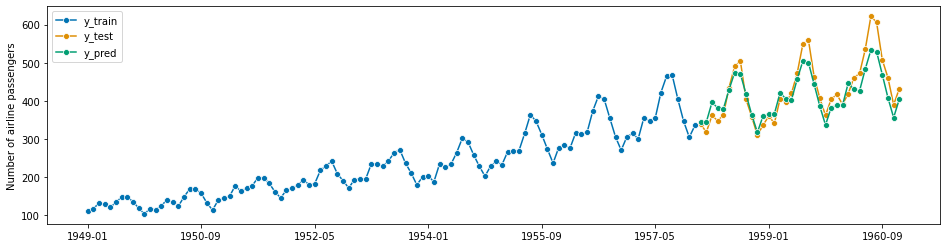

In [22]:
from sktime.forecasting.ets import AutoETS

forecaster = AutoETS(auto=True, sp=12, n_jobs=-1)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
smape_loss(y_test, y_pred)

0.04117062367046531

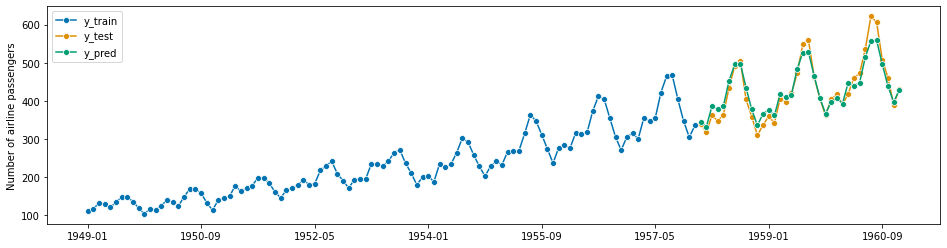

In [23]:
forecaster = AutoARIMA(sp=12, suppress_warnings=True)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
smape_loss(y_test, y_pred)

## Ensembling

In [24]:
help(EnsembleForecaster)

Help on class EnsembleForecaster in module sktime.forecasting.compose._ensemble:

class EnsembleForecaster(sktime.forecasting.base._sktime._OptionalForecastingHorizonMixin, sktime.forecasting.base._meta._HeterogenousEnsembleForecaster)
 |  Ensemble of forecasters
 |  
 |  Parameters
 |  ----------
 |  forecasters : list of (str, estimator) tuples
 |  n_jobs : int or None, optional (default=None)
 |      The number of jobs to run in parallel for fit. None means 1 unless
 |      in a joblib.parallel_backend context.
 |      -1 means using all processors.
 |  
 |  Method resolution order:
 |      EnsembleForecaster
 |      sktime.forecasting.base._sktime._OptionalForecastingHorizonMixin
 |      sktime.forecasting.base._meta._HeterogenousEnsembleForecaster
 |      sktime.forecasting.base._sktime._SktimeForecaster
 |      sktime.forecasting.base._base.BaseForecaster
 |      sktime.base._meta._HeterogenousMetaEstimator
 |      sktime.base._base.BaseEstimator
 |      sklearn.base.BaseEstimato

0.07854053582629221

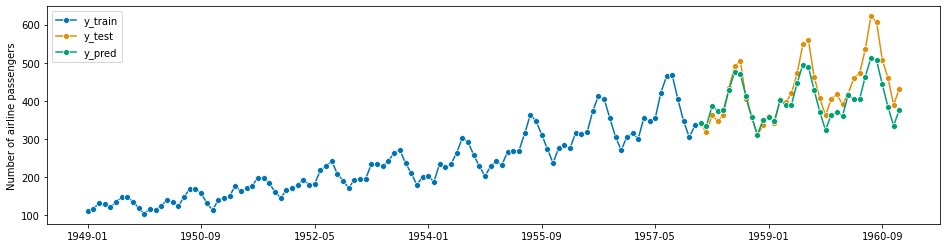

In [27]:
forecaster = EnsembleForecaster(
    [
        ("ses", ExponentialSmoothing(seasonal="multiplicative", sp=12)),
        (
            "holt",
            ExponentialSmoothing(
                trend="add", damped_trend=False, seasonal="multiplicative", sp=12
            ),
        ),
        (
            "damped",
            ExponentialSmoothing(
                trend="add", damped_trend=True, seasonal="multiplicative", sp=12
            ),
        ),
    ]
)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_test, y_pred)

0.04942764864434326

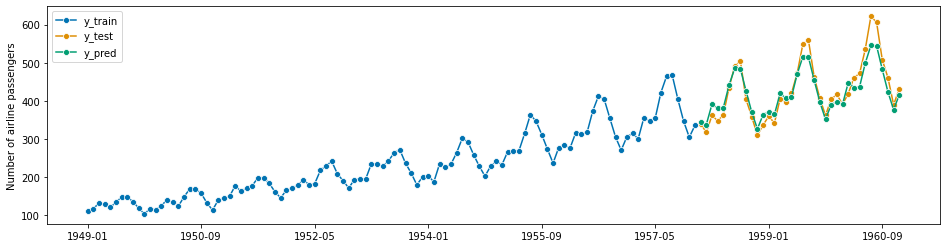

In [28]:
# My Variant
forecaster = EnsembleForecaster([
#     ("ses", ExponentialSmoothing(seasonal="multiplicative", sp=12)),
#     ("holt", ExponentialSmoothing(trend="add", damped=False, seasonal="multiplicative", sp=12)),
#     ("damped", ExponentialSmoothing(trend="add", damped=True, seasonal="multiplicative", sp=12)),
    ("autoARIMA", AutoARIMA(sp=12, suppress_warnings=True)),
    ("autoETS", AutoETS(auto=True, sp=12, n_jobs=-1))
])
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
smape_loss(y_test, y_pred)

## Tuning

In [ ]:
regressor

In [ ]:
help(ForecastingGridSearchCV)

In [ ]:
# fh

In [ ]:
forecaster = ReducedRegressionForecaster(regressor=regressor, window_length=15, strategy="recursive")
param_grid = {"window_length": [5, 10, 15]}

# we fit the forecaster on the initial window, and then use temporal cross-validation to find the optimal parameter
cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.5), start_with_window=True)
gscv = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=param_grid, verbose=1)
gscv.fit(y_train)
y_pred = gscv.predict(fh)

In [ ]:
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
smape_loss(y_test, y_pred)

In [ ]:
gscv.best_params_

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# tuning the 'n_estimator' hyperparameter of RandomForestRegressor from scikit-learn
regressor_param_grid = {"n_estimators": [100, 200, 300]}
forecaster_param_grid = {"window_length": [5,10,15,20,25]}

# create a tunnable regressor with GridSearchCV
regressor = GridSearchCV(RandomForestRegressor(), param_grid=regressor_param_grid)
forecaster = ReducedRegressionForecaster(regressor, window_length=15, strategy="recursive")

cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.5))
gscv = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=forecaster_param_grid)

gscv.fit(y_train)
y_pred = gscv.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
smape_loss(y_test, y_pred)

In [ ]:
print(gscv.best_params_, gscv.best_forecaster_.regressor_.best_params_)

In [ ]:
gscv.cv_results_

In [ ]:
forecaster

In [ ]:
gscv = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=forecaster_param_grid, scoring=sMAPE())
gscv.fit(y_train)
pd.DataFrame(gscv.cv_results_)

## Detrending

In [ ]:
# liner detrending
forecaster = PolynomialTrendForecaster(degree=1)
transformer = Detrender(forecaster=forecaster)
yt = transformer.fit_transform(y_train)

# internally, the Detrender uses the in-sample predictions of the PolynomialTrendForecaster
forecaster = PolynomialTrendForecaster(degree=1)
fh_ins = -np.arange(len(y_train)) # in-sample forecasting horizon
y_pred = forecaster.fit(y_train).predict(fh=fh_ins)

plot_series(y_train, y_pred, yt, labels=["y_train", "fitted linear trend", "residuals"]);

### Deseasonalizing

In [ ]:
# additive
transformer_add = Deseasonalizer(model='additive', sp=12)
yt_add = transformer_add.fit_transform(y_train)

# multiplicative
transformer_mult = Deseasonalizer(model='multiplicative', sp=12)
yt_mult = transformer_mult.fit_transform(y_train)

plot_series(y_train, yt_add, yt_mult, labels=["y_train", "deseasonalized_add", "deseasonalized_mult"]);

### Pipelining

In [ ]:
regressor

In [ ]:
forecaster = TransformedTargetForecaster([
    ("deseasonalise", Deseasonalizer(model="multiplicative", sp=12)),
    ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
    ("forecast", ReducedRegressionForecaster(regressor=regressor, window_length=12, strategy="recursive"))
])
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
smape_loss(y_test, y_pred)

## Temporal Cross Validation for AutoARIMA

Does not seem to be working. sp=12 is not giving same results as before

In [29]:
y = load_airline()
y_train, y_test = temporal_train_test_split(y, test_size=36)

fh = ForecastingHorizon(np.arange(len(y_test)) + 1, is_relative=True)

AutoARIMA(sp=12, suppress_warnings=True)


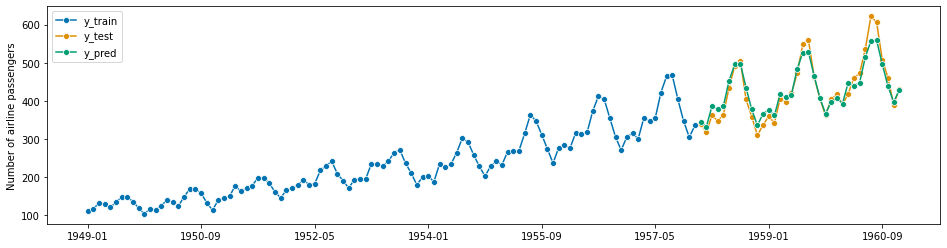

In [30]:
forecaster = AutoARIMA(sp=12, suppress_warnings=True)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
smape_loss(y_test, y_pred)
print(forecaster)

### `sp` in grid search (does not work)

Bug report filed: https://github.com/alan-turing-institute/sktime/issues/522

In [36]:
regressor = KNeighborsRegressor()
print(f"Original n_neighbors: {regressor.get_params()['n_neighbors']}")

regressor.set_params(n_neighbors=1)
print(f"\nAfter manually setting n_neighbors: {regressor.get_params()['n_neighbors']}")

Original n_neighbors: 5

After manually setting n_neighbors: 1


In [37]:
from pmdarima import AutoARIMA as _AutoARIMA

native_model = _AutoARIMA()
print(getattr(native_model, 'm'))
setattr(native_model, 'sp', 12)
print(getattr(native_model, 'm'))

1
1


In [35]:
forecaster.

AttributeError: 'AutoARIMA' object has no attribute '_forecaster'

In [ ]:
forecaster.

In [39]:
forecaster = AutoARIMA(suppress_warnings=True)
print(f"Original sp: {forecaster.get_params()['sp']}")
print(f"Original _Forecaster: {forecaster._forecaster}")
print(f"Original _Forecaster sp: {forecaster._forecaster.m}")

forecaster.set_params(sp=3)
print(f"\nAfter manually setting sp: {forecaster.get_params()['sp']}")
print(f"After manually setting sp _Forecaster: {forecaster._forecaster}")
print(f"After manually setting sp _Forecaster sp: {forecaster._forecaster.m}")

Original sp: 1


AttributeError: 'AutoARIMA' object has no attribute '_forecaster'

In [ ]:
# tuning the 'n_estimator' hyperparameter of RandomForestRegressor from scikit-learn
# regressor_param_grid = {"n_estimators": [100, 200, 300]}
# forecaster_param_grid = {"window_length": [5,10,15,20,25]}
forecaster_param_grid = {'sp': [3, 12]}

# create a tunnable regressor with GridSearchCV
# forecaster = ReducedRegressionForecaster(regressor, window_length=15, strategy="recursive")
# forecaster = AutoARIMA(sp=12, suppress_warnings=True)
forecaster = AutoARIMA(suppress_warnings=True)

cv = SlidingWindowSplitter(
    initial_window=int(len(y_train) * 0.5),
    start_with_window=True,
    window_length=36,
    # fh=np.arange(12) + 1  # Not Supported Yet (Prediction can only be the next time point for now)
)
print(f"Forecast_horizon: {cv.get_fh()}")
print(f"Window Length: {cv.window_length}")
gscv = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=forecaster_param_grid, verbose=True)

gscv.fit(y_train)
y_pred = gscv.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
smape_loss(y_test, y_pred)

In [ ]:
gscv.cv_results_

In [ ]:
np.array([0.37408572, 0.29277678])

In [ ]:
gscv.best_forecaster_

### `sp` in forecaster (works)

In [ ]:
# tuning the 'n_estimator' hyperparameter of RandomForestRegressor from scikit-learn
# regressor_param_grid = {"n_estimators": [100, 200, 300]}
# forecaster_param_grid = {"window_length": [5,10,15,20,25]}
forecaster_param_grid = {}

# create a tunnable regressor with GridSearchCV
# forecaster = ReducedRegressionForecaster(regressor, window_length=15, strategy="recursive")
forecaster = AutoARIMA(sp=12, suppress_warnings=True)
# forecaster = AutoARIMA(suppress_warnings=True)

cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.9), start_with_window=True)
gscv = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=forecaster_param_grid, verbose=True)

gscv.fit(y_train)
y_pred = gscv.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
smape_loss(y_test, y_pred)

### `sp` manual grid search

In [ ]:
# tuning the 'n_estimator' hyperparameter of RandomForestRegressor from scikit-learn
# regressor_param_grid = {"n_estimators": [100, 200, 300]}
# forecaster_param_grid = {"window_length": [5,10,15,20,25]}
forecaster_param_grid = {'sp': [3, 6, 12]}

# create a tunnable regressor with GridSearchCV
# forecaster = ReducedRegressionForecaster(regressor, window_length=15, strategy="recursive")

def ARIMA_gc(param_grid):
    candidate_params = ParameterGrid(param_grid)
    candidate_params = list(candidate_params)
    n_candidates = len(candidate_params)
    
    print(candidate_params)
    print(n_candidates)
    
    base_forecaster = AutoARIMA(suppress_warnings=True)
        
    all_cvs = []
    for parameters in candidate_params:
        # Fit params
        if parameters is not None:
            forecaster = clone(base_forecaster)
            forecaster.set_params(**parameters)
            print(forecaster)
            
            cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.9), start_with_window=False)
            gscv = ForecastingGridSearchCV(forecaster, cv=cv, param_grid={}, verbose=True)
    
            gscv.fit(y_train)
            all_cvs.append(gscv)
            
            y_pred = gscv.predict(fh)
            plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
            smape_loss(y_test, y_pred)

    return all_cvs
            
all_cvs = ARIMA_gc(param_grid=forecaster_param_grid)

In [ ]:
all_cvs

In [ ]:
from pprint import pprint

test_metrics = []
for gscv in all_cvs:
    print("-"*50)
    print(f"{gscv.best_forecaster_}")
    print("-"*50)
    pprint(f"Results: {gscv.cv_results_}")
    pprint(f"Fitted Params: {gscv.get_fitted_params()}") 
    print(gscv.best_score_)
    test_metrics.append(gscv.best_score_)
    
best_index = test_metrics.index(min(test_metrics))
print(f"All Metrics: {test_metrics}")
print(f"Best Index: {best_index}")

y_pred = all_cvs[best_index].predict(fh)  
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
smape_loss(y_test, y_pred)      

# Multivariate

## Data

In [ ]:
y, X = load_longley()
display(y)
display(X)

In [ ]:
plot_series(y)

In [ ]:
from sktime import show_versions; show_versions()